# Hyperparameter Optimization con Optuna

¡Bienvenido al tutorial de optimización de hiperparámetros basado en Optuna! En este notebook interactivo, explorarás el mundo del hyperparameter tuning para una Red Neuronal Convolucional (CNN) orientada específicamente a la clasificación de imágenes utilizando el dataset CIFAR-10. La optimización de hiperparámetros es fundamental para mejorar el rendimiento del modelo, logrando que tus modelos sean más precisos y eficientes.

Optuna, una librería robusta y versátil, desempeña un papel central en la automatización y simplificación de este proceso. Te permite navegar a través de espacios de hiperparámetros complejos con facilidad. En este tutorial, interactuarás con las funcionalidades principales de Optuna y también tendrás la oportunidad de construir una arquitectura CNN flexible. Este diseño adaptable es esencial para comprender cómo los modelos pueden ajustarse sin esfuerzo para adaptarse a diversas configuraciones de hiperparámetros.

A lo largo de esta sesión:
- Aprenderás cómo configurar y ejecutar un study de Optuna, incorporando todos los elementos esenciales requeridos para una optimización de hiperparámetros efectiva.
- Realizarás un análisis exhaustivo de los resultados para evaluar cómo los diferentes hiperparámetros influyen en el rendimiento del modelo, obteniendo información sobre su impacto práctico.

Además, este tutorial incluye una sección opcional donde compararás dos métodos prevalentes de optimización de hiperparámetros: el método de muestreo por defecto de Optuna (Tree-structured Parzen Estimator, o TPE) y el método tradicional de Grid Search. Esta comparación no solo resaltará las fortalezas de Optuna, sino que también proporcionará una perspectiva más clara sobre cómo puede superar a las técnicas de optimización convencionales.

## Import Libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import optuna
import matplotlib.pyplot as plt
import helper_utils
import torch.nn.functional as F
from pprint import pprint

helper_utils.set_seed(15)

In [2]:
# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


## Optimización de Hiperparámetros para CNNs en CIFAR-10

En esta sección, explorarás la tarea vital de encontrar los hiperparámetros óptimos para una Red Neuronal Convolucional (CNN) adaptada al dataset CIFAR-10. 
Utilizando Optuna, un framework sofisticado para la optimización de hiperparámetros, tu objetivo es agilizar y automatizar el proceso, asegurando eficiencia y efectividad. 
La selección de hiperparámetros es notablemente intensiva a nivel computacional y depende de varios factores, incluyendo la arquitectura del modelo, las características del dataset y los procesos específicos de entrenamiento involucrados. Estos elementos, colectiva e individualmente, tienen impactos significativos en los resultados de rendimiento del modelo.

### Definiendo una Arquitectura CNN Flexible

La arquitectura del modelo aquí está diseñada deliberadamente para ser flexible, permitiendo variabilidad en sus capas, lo cual es fundamental para adaptarse a las diferentes configuraciones de hiperparámetros sugeridas por Optuna durante los trials de optimización.
La arquitectura se define de manera modular, lo que permite realizar ajustes y experimentar fácilmente con diferentes configuraciones de capas, funciones de activación y otros hiperparámetros.



`FlexibleCNN` es una clase que encapsula la arquitectura del modelo CNN:

* **`__init__`**: El constructor inicializa las capas de extracción de características (feature extraction) del modelo.
    * Construye una serie de bloques convolucionales basados en el parámetro `n_layers`. Cada bloque es una secuencia de `nn.Conv2d`, `nn.ReLU` y `nn.MaxPool2d`.
    * El `in_channels` para cada bloque se establece según el `out_channels` del bloque precedente para asegurar un flujo de datos continuo.
    * Todos los bloques se combinan en un único módulo `nn.Sequential` asignado al atributo `.features`, que maneja la extracción de características.
    * El clasificador, `.classifier`, se establece inicialmente como `None` y se construirá dinámicamente más adelante.

* **`_create_classifier`**: Este método auxiliar construye dinámicamente la parte del clasificador de la red.
    * Se llama durante el primer forward pass una vez que se conoce el tamaño de entrada para las capas lineales.

* **`forward`**: Este método define el forward pass del modelo.
    * La entrada `x` pasa primero por las capas `.features`.
    * La salida del extractor de características se aplana (flatten) para determinar el tamaño de entrada del clasificador.
    * Si el `.classifier` aún no se ha creado, llama a `_create_classifier` para construirlo sobre la marcha.
    * Finalmente, los datos aplanados pasan a través del `.classifier` para producir la salida final.

In [3]:
class FlexibleCNN(nn.Module):
    """
    Una Red Neuronal Convolucional flexible con un clasificador creado dinámicamente.

    La arquitectura de esta CNN se define mediante los hiperparámetros proporcionados,
    lo que permite un número variable de capas convolucionales. El clasificador
    (capas totalmente conectadas) se construye durante el primer forward pass
    para adaptarse al tamaño de salida del extractor de características convolucional.
    """
    def __init__(self, n_layers, n_filters, kernel_sizes, dropout_rate, fc_size):
        """
        Inicializa la parte de extracción de características de la CNN.

        Args:
            n_layers: El número de bloques convolucionales a crear.
            n_filters: Una lista de enteros que especifica el número de filtros
                       de salida para cada bloque convolucional.
            kernel_sizes: Una lista de enteros que especifica el tamaño del kernel
                          para cada capa convolucional.
            dropout_rate: La probabilidad de dropout que se utilizará en el clasificador.
            fc_size: El número de neuronas en la capa oculta totalmente conectada.
        """
        super(FlexibleCNN, self).__init__()

        # Inicializa una lista vacía para contener los bloques convolucionales
        blocks = []
        # Establece el número inicial de canales de entrada para imágenes RGB
        in_channels = 3

        # Bucle para construir cada bloque convolucional
        for i in range(n_layers):

            # Obtiene los parámetros para la capa convolucional actual
            out_channels = n_filters[i]
            kernel_size = kernel_sizes[i]
            # Calcula el padding para mantener las dimensiones espaciales de entrada (padding 'same')
            padding = (kernel_size - 1) // 2

            # Define un bloque como una secuencia de capas Conv, ReLU y MaxPool
            block = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size, padding=padding),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2, stride=2)
            )
            
            # Añade el bloque recién creado a la lista
            blocks.append(block)

            # Actualiza el número de canales de entrada para el siguiente bloque
            in_channels = out_channels

        # Combina todos los bloques en un único módulo extractor de características
        self.features = nn.Sequential(*blocks)

        # Almacena los hiperparámetros necesarios para construir el clasificador más tarde
        self.dropout_rate = dropout_rate
        self.fc_size = fc_size

        # El clasificador se inicializará dinámicamente en el forward pass
        self.classifier = None

    def _create_classifier(self, flattened_size, device):
        """
        Crea e inicializa dinámicamente la parte del clasificador de la red.

        Este método auxiliar se llama durante el primer forward pass para construir las
        capas totalmente conectadas basándose en el tamaño del mapa de características
        de la base convolucional.

        Args:
            flattened_size: El número de características de entrada para la primera capa lineal,
                            determinado a partir del mapa de características aplanado.
            device: El dispositivo al que deben moverse las nuevas capas del clasificador.
        """
        # Define la arquitectura del clasificador
        self.classifier = nn.Sequential(
            nn.Dropout(self.dropout_rate),
            nn.Linear(flattened_size, self.fc_size),
            nn.ReLU(inplace=True),
            nn.Dropout(self.dropout_rate),
            nn.Linear(self.fc_size, 10)  # Asume 10 clases de salida (ej., CIFAR-10)
        ).to(device)

    def forward(self, x):
        """
        Define el forward pass del modelo.

        Args:
            x: El tensor de entrada de forma (batch_size, channels, height, width).

        Returns:
            Los logits de salida del clasificador.
        """
        # Obtiene el dispositivo del tensor de entrada para asegurar la consistencia
        device = x.device

        # Pasa la entrada a través de las capas de extracción de características
        x = self.features(x)

        # Aplana el mapa de características para prepararlo para las capas totalmente conectadas
        flattened = torch.flatten(x, 1)
        flattened_size = flattened.size(1)

        # Si el clasificador aún no se ha creado, lo inicializa
        if self.classifier is None:
            self._create_classifier(flattened_size, device)

        # Pasa las características aplanadas por el clasificador para obtener la salida final
        return self.classifier(flattened)

## Definiendo la Función Objetivo de Optuna

La función objetivo (objective function) es el núcleo del proceso de optimización de hiperparámetros, siendo la función que Optuna llamará repetidamente para evaluar diferentes configuraciones de hiperparámetros.
Esta función encapsula todo el proceso de entrenamiento y evaluación, incluyendo la definición de la arquitectura del modelo CNN, el optimizer, los data loaders, el training loop y las métricas de evaluación.
Dentro de esta función, defines el espacio de búsqueda para los hiperparámetros utilizando los métodos `trial.suggest_*`, que permiten a Optuna muestrear hiperparámetros de un rango definido o un conjunto de valores. 
Para obtener una lista completa de los métodos `suggest_*` disponibles, puedes consultar la [documentación de Optuna](https://optuna.readthedocs.io/en/stable/reference/generated/optuna.trial.Trial.html).

*La función objetivo está diseñada para devolver un único valor escalar, que representa el rendimiento del modelo para los hiperparámetros dados*. 
En tu caso, el objetivo es maximizar el accuracy del modelo en el conjunto de validación, el cual se calcula mediante la función `evaluate_accuracy`.

**Inicialización Dinámica de Capas**: Una adición digna de mención en esta función objetivo es el paso de inicialización que involucra una entrada ficticia (dummy input). Debido a que `FlexibleCNN` crea sus capas de clasificador dinámicamente durante el primer forward pass, estos parámetros no existen inmediatamente después de instanciar el modelo.
- **¿Por qué usar una entrada ficticia?** Pasar datos a través del modelo lo obliga a calcular el tamaño de la característica aplanada (flattened feature size) y a construir las capas del clasificador. Debes hacer esto *antes* de definir el optimizer para que `model.parameters()` incluya los pesos del clasificador. De lo contrario, el optimizer solo rastrearía el extractor de características, dejando al clasificador sin entrenar.
- **¿Por qué estas dimensiones?** Se utiliza el tensor `torch.randn(1, 3, 32, 32)` para imitar la estructura del dataset CIFAR-10. Representa una sola imagen (batch size de 1) con 3 canales de color (RGB) y una resolución de `32x32` píxeles.

Observa que algunos hiperparámetros se definen como valores fijos, como el número de epochs, el batch size y el learning rate.

In [4]:
def objective(trial, device):
    """
    Define la función objetivo para la optimización de hiperparámetros utilizando Optuna.

    Para cada trial, esta función muestrea un conjunto de hiperparámetros,
    construye un modelo, lo entrena durante un número fijo de epochs, evalúa
    su rendimiento en un conjunto de validación y devuelve el accuracy. Optuna
    utiliza el accuracy devuelto para guiar su búsqueda de la mejor
    combinación de hiperparámetros.

    Args:
        trial: Un objeto `Trial` de Optuna, utilizado para muestrear hiperparámetros.
        device: El dispositivo ('cpu' o 'cuda') para el entrenamiento y evaluación del modelo.

    Returns:
        El validation accuracy del modelo entrenado como un float.
    """
    # Muestrear hiperparámetros para el extractor de características usando el trial de Optuna
    n_layers = trial.suggest_int("n_layers", 1, 3)
    n_filters = [trial.suggest_int(f"n_filters_{i}", 16, 128) for i in range(n_layers)]
    kernel_sizes = [trial.suggest_categorical(f"kernel_size_{i}", [3, 5]) for i in range(n_layers)]

    # Muestrear hiperparámetros para el clasificador
    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5)
    fc_size = trial.suggest_int("fc_size", 64, 256)

    # Instanciar el modelo con los hiperparámetros muestreados
    model = FlexibleCNN(n_layers, n_filters, kernel_sizes, dropout_rate, fc_size).to(device)

    # Inicializar la capa dinámica del clasificador pasando una entrada ficticia (dummy input) por el modelo
    # Esto asegura que todos los parámetros estén instanciados antes de definir el optimizer
    dummy_input = torch.randn(1, 3, 32, 32).to(device)
    model(dummy_input)

    # Definir parámetros de entrenamiento fijos: learning rate, loss function y optimizer
    learning_rate = 0.001
    loss_fcn = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Definir parámetros fijos de carga de datos y crear data loaders
    batch_size = 128
    train_loader, val_loader = helper_utils.get_dataset_dataloaders(batch_size=batch_size)

    # Definir el número fijo de epochs para el entrenamiento
    n_epochs = 10
    # Entrenar el modelo utilizando una función auxiliar (helper function)
    helper_utils.train_model(
        model=model,
        optimizer=optimizer,
        train_dataloader=train_loader,
        n_epochs=n_epochs,
        loss_fcn=loss_fcn,
        device=device
    )

    # Evaluar la precisión (accuracy) del modelo entrenado en el conjunto de validación
    accuracy = helper_utils.evaluate_accuracy(model, val_loader, device)
    
    # Devolver el accuracy final para este trial
    return accuracy

## Ejecutando el Study de Optuna

Una vez definida la función objetivo, se crea un "study" (estudio) de Optuna para gestionar el proceso de optimización de hiperparámetros.
El estudio es responsable de ejecutar la función objetivo múltiples veces con diferentes configuraciones de hiperparámetros, lo que permite a Optuna explorar el espacio de búsqueda y encontrar los mejores hiperparámetros.

En este caso, tu objetivo es **maximizar el accuracy** del modelo CNN en el dataset CIFAR-10; por esta razón, utilizamos `direction='maximize'` al crear el estudio.
Se llama al método `optimize` del estudio para iniciar el proceso de optimización, el cual ejecutará la función objetivo durante un número definido de trials (intentos).

Se utiliza una función lambda para pasar el `device` (dispositivo) a la función objetivo, permitiendo que el modelo se entrene en el dispositivo especificado.
*Nota*: También puedes pasar otros parámetros a la función objetivo utilizando la función lambda, si fuera necesario.

**NOTA:** El código a continuación tardará aproximadamente 8 minutos en ejecutarse.

In [5]:
# Crear un objeto de estudio (study) y optimizar la función objetivo
study = optuna.create_study(direction='maximize') # El objetivo en este caso es maximizar el accuracy

# Iniciar el proceso de optimización (tarda unos 8 minutos para 20 trials)
n_trials = 20
study.optimize(lambda trial: objective(trial, device), n_trials=n_trials) # usa más trials en la práctica

[I 2026-01-25 14:47:50,181] A new study created in memory with name: no-name-28463a1d-7e2d-4cb3-915f-41b5e46b4190
100%|██████████| 170M/170M [00:08<00:00, 20.1MB/s] 
/home/keras/wordspaces/Pytorch-for-Deep-Learning/.venv/lib/python3.12/site-packages/torchvision/datasets/cifar.py:83: VisibleDeprecationWarning: dtype(): align should be passed as Python or NumPy boolean but got `align=0`. Did you mean to pass a tuple to create a subarray type? (Deprecated NumPy 2.4)
  entry = pickle.load(f, encoding="latin1")


Current Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Current Batch:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 5 - Train Loss: 1.4346
Epoch 10 - Train Loss: 1.1751
Training complete!



Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

[I 2026-01-25 14:49:44,491] Trial 0 finished with value: 0.546 and parameters: {'n_layers': 1, 'n_filters_0': 93, 'kernel_size_0': 3, 'dropout_rate': 0.41977219134371024, 'fc_size': 218}. Best is trial 0 with value: 0.546.


Evaluation complete.


Current Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Current Batch:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 5 - Train Loss: 1.1741
Epoch 10 - Train Loss: 0.6989
Training complete!



Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

[I 2026-01-25 14:51:30,616] Trial 1 finished with value: 0.6095 and parameters: {'n_layers': 3, 'n_filters_0': 107, 'n_filters_1': 127, 'n_filters_2': 65, 'kernel_size_0': 5, 'kernel_size_1': 3, 'kernel_size_2': 5, 'dropout_rate': 0.10988710771294247, 'fc_size': 111}. Best is trial 1 with value: 0.6095.


Evaluation complete.


Current Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Current Batch:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 5 - Train Loss: 1.3218
Epoch 10 - Train Loss: 1.0987
Training complete!



Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

[I 2026-01-25 14:52:20,901] Trial 2 finished with value: 0.588 and parameters: {'n_layers': 2, 'n_filters_0': 76, 'n_filters_1': 31, 'kernel_size_0': 5, 'kernel_size_1': 3, 'dropout_rate': 0.4739909819858287, 'fc_size': 235}. Best is trial 1 with value: 0.6095.


Evaluation complete.


Current Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Current Batch:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 5 - Train Loss: 1.3205
Epoch 10 - Train Loss: 1.0504
Training complete!



Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

[I 2026-01-25 14:53:00,873] Trial 3 finished with value: 0.5815 and parameters: {'n_layers': 2, 'n_filters_0': 48, 'n_filters_1': 20, 'kernel_size_0': 5, 'kernel_size_1': 5, 'dropout_rate': 0.31961800730618595, 'fc_size': 167}. Best is trial 1 with value: 0.6095.


Evaluation complete.


Current Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Current Batch:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 5 - Train Loss: 1.3379
Epoch 10 - Train Loss: 1.0707
Training complete!



Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

[I 2026-01-25 14:54:24,522] Trial 4 finished with value: 0.5695 and parameters: {'n_layers': 1, 'n_filters_0': 69, 'kernel_size_0': 5, 'dropout_rate': 0.4720495709427134, 'fc_size': 206}. Best is trial 1 with value: 0.6095.


Evaluation complete.


Current Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Current Batch:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 5 - Train Loss: 1.2983
Epoch 10 - Train Loss: 1.0695
Training complete!



Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

[I 2026-01-25 14:56:01,145] Trial 5 finished with value: 0.607 and parameters: {'n_layers': 2, 'n_filters_0': 87, 'n_filters_1': 79, 'kernel_size_0': 3, 'kernel_size_1': 5, 'dropout_rate': 0.485353829649912, 'fc_size': 162}. Best is trial 1 with value: 0.6095.


Evaluation complete.


Current Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Current Batch:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 5 - Train Loss: 1.1561
Epoch 10 - Train Loss: 0.7365
Training complete!



Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

[I 2026-01-25 14:57:27,791] Trial 6 finished with value: 0.572 and parameters: {'n_layers': 1, 'n_filters_0': 97, 'kernel_size_0': 3, 'dropout_rate': 0.14279408909413338, 'fc_size': 144}. Best is trial 1 with value: 0.6095.


Evaluation complete.


Current Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Current Batch:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 5 - Train Loss: 1.3764
Epoch 10 - Train Loss: 1.1617
Training complete!



Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

[I 2026-01-25 14:58:42,965] Trial 7 finished with value: 0.5685 and parameters: {'n_layers': 2, 'n_filters_0': 119, 'n_filters_1': 16, 'kernel_size_0': 3, 'kernel_size_1': 5, 'dropout_rate': 0.3415343542961067, 'fc_size': 159}. Best is trial 1 with value: 0.6095.


Evaluation complete.


Current Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Current Batch:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 5 - Train Loss: 1.3182
Epoch 10 - Train Loss: 1.0516
Training complete!



Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

[I 2026-01-25 14:59:55,260] Trial 8 finished with value: 0.5785 and parameters: {'n_layers': 2, 'n_filters_0': 81, 'n_filters_1': 49, 'kernel_size_0': 5, 'kernel_size_1': 3, 'dropout_rate': 0.3995610042169674, 'fc_size': 112}. Best is trial 1 with value: 0.6095.


Evaluation complete.


Current Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Current Batch:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 5 - Train Loss: 1.3536
Epoch 10 - Train Loss: 1.0702
Training complete!



Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

[I 2026-01-25 15:01:06,751] Trial 9 finished with value: 0.607 and parameters: {'n_layers': 3, 'n_filters_0': 62, 'n_filters_1': 62, 'n_filters_2': 110, 'kernel_size_0': 3, 'kernel_size_1': 5, 'kernel_size_2': 5, 'dropout_rate': 0.4045309226238424, 'fc_size': 96}. Best is trial 1 with value: 0.6095.


Evaluation complete.


Current Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Current Batch:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 5 - Train Loss: 1.4160
Epoch 10 - Train Loss: 1.1406
Training complete!



Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

[I 2026-01-25 15:01:51,885] Trial 10 finished with value: 0.556 and parameters: {'n_layers': 3, 'n_filters_0': 20, 'n_filters_1': 127, 'n_filters_2': 40, 'kernel_size_0': 5, 'kernel_size_1': 3, 'kernel_size_2': 3, 'dropout_rate': 0.13865766778186656, 'fc_size': 73}. Best is trial 1 with value: 0.6095.


Evaluation complete.


Current Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Current Batch:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 5 - Train Loss: 1.2064
Epoch 10 - Train Loss: 0.8286
Training complete!



Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

[I 2026-01-25 15:03:45,004] Trial 11 finished with value: 0.6245 and parameters: {'n_layers': 3, 'n_filters_0': 128, 'n_filters_1': 109, 'n_filters_2': 73, 'kernel_size_0': 3, 'kernel_size_1': 3, 'kernel_size_2': 5, 'dropout_rate': 0.20860372394952606, 'fc_size': 131}. Best is trial 11 with value: 0.6245.


Evaluation complete.


Current Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Current Batch:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 5 - Train Loss: 1.2594
Epoch 10 - Train Loss: 0.8635
Training complete!



Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

[I 2026-01-25 15:05:45,533] Trial 12 finished with value: 0.6275 and parameters: {'n_layers': 3, 'n_filters_0': 127, 'n_filters_1': 128, 'n_filters_2': 74, 'kernel_size_0': 3, 'kernel_size_1': 3, 'kernel_size_2': 5, 'dropout_rate': 0.2140310210049341, 'fc_size': 122}. Best is trial 12 with value: 0.6275.


Evaluation complete.


Current Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Current Batch:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 5 - Train Loss: 1.1903
Epoch 10 - Train Loss: 0.7809
Training complete!



Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

[I 2026-01-25 15:07:41,429] Trial 13 finished with value: 0.6305 and parameters: {'n_layers': 3, 'n_filters_0': 128, 'n_filters_1': 101, 'n_filters_2': 85, 'kernel_size_0': 3, 'kernel_size_1': 3, 'kernel_size_2': 5, 'dropout_rate': 0.215520139583682, 'fc_size': 135}. Best is trial 13 with value: 0.6305.


Evaluation complete.


Current Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Current Batch:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 5 - Train Loss: 1.3049
Epoch 10 - Train Loss: 0.9357
Training complete!



Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

[I 2026-01-25 15:09:26,767] Trial 14 finished with value: 0.605 and parameters: {'n_layers': 3, 'n_filters_0': 112, 'n_filters_1': 98, 'n_filters_2': 90, 'kernel_size_0': 3, 'kernel_size_1': 3, 'kernel_size_2': 5, 'dropout_rate': 0.2348218894665124, 'fc_size': 64}. Best is trial 13 with value: 0.6305.


Evaluation complete.


Current Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Current Batch:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 5 - Train Loss: 1.1853
Epoch 10 - Train Loss: 0.7816
Training complete!



Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

[I 2026-01-25 15:11:23,439] Trial 15 finished with value: 0.609 and parameters: {'n_layers': 3, 'n_filters_0': 128, 'n_filters_1': 100, 'n_filters_2': 89, 'kernel_size_0': 3, 'kernel_size_1': 3, 'kernel_size_2': 5, 'dropout_rate': 0.24186838630221075, 'fc_size': 192}. Best is trial 13 with value: 0.6305.


Evaluation complete.


Current Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Current Batch:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 5 - Train Loss: 1.2632
Epoch 10 - Train Loss: 0.8687
Training complete!



Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

[I 2026-01-25 15:12:53,084] Trial 16 finished with value: 0.58 and parameters: {'n_layers': 3, 'n_filters_0': 106, 'n_filters_1': 85, 'n_filters_2': 128, 'kernel_size_0': 3, 'kernel_size_1': 3, 'kernel_size_2': 3, 'dropout_rate': 0.1955372251220393, 'fc_size': 131}. Best is trial 13 with value: 0.6305.


Evaluation complete.


Current Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Current Batch:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 5 - Train Loss: 1.3886
Epoch 10 - Train Loss: 1.0842
Training complete!



Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

[I 2026-01-25 15:13:50,912] Trial 17 finished with value: 0.601 and parameters: {'n_layers': 3, 'n_filters_0': 44, 'n_filters_1': 112, 'n_filters_2': 61, 'kernel_size_0': 3, 'kernel_size_1': 3, 'kernel_size_2': 5, 'dropout_rate': 0.2785036853263738, 'fc_size': 97}. Best is trial 13 with value: 0.6305.


Evaluation complete.


Current Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Current Batch:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 5 - Train Loss: 1.3551
Epoch 10 - Train Loss: 1.0630
Training complete!



Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

[I 2026-01-25 15:15:31,454] Trial 18 finished with value: 0.5545 and parameters: {'n_layers': 3, 'n_filters_0': 118, 'n_filters_1': 115, 'n_filters_2': 19, 'kernel_size_0': 3, 'kernel_size_1': 3, 'kernel_size_2': 5, 'dropout_rate': 0.17375128059090295, 'fc_size': 183}. Best is trial 13 with value: 0.6305.


Evaluation complete.


Current Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Current Batch:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 5 - Train Loss: 1.1872
Epoch 10 - Train Loss: 0.8637
Training complete!



Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

[I 2026-01-25 15:16:15,272] Trial 19 finished with value: 0.595 and parameters: {'n_layers': 2, 'n_filters_0': 18, 'n_filters_1': 93, 'kernel_size_0': 3, 'kernel_size_1': 3, 'dropout_rate': 0.2685072928198303, 'fc_size': 137}. Best is trial 13 with value: 0.6305.


Evaluation complete.


### Analizando los Resultados
Una vez completado el proceso de optimización, puedes analizar los resultados para comprender qué hiperparámetros produjeron el mejor rendimiento.
El objeto `study` contiene una gran cantidad de información sobre los trials, incluyendo los hiperparámetros muestreados, las métricas de rendimiento correspondientes y el mejor trial (best trial).

Puedes acceder al DataFrame completo de los trials utilizando el método `trials_dataframe()`, el cual proporciona una visión general exhaustiva de todos los trials realizados durante el proceso de optimización.
Este DataFrame incluye columnas para el número de trial, los hiperparámetros y el valor objetivo (en nuestro caso, el accuracy).

Para acceder a los mejores hiperparámetros y al mejor trial, puedes utilizar los atributos `best_trial` del objeto study.

**Nota:** estos resultados pueden cambiar cada vez que vuelvas a ejecutar el estudio de entrenamiento.

In [6]:
# Extract the dataframe with the results
df = study.trials_dataframe()

df

,number,value,datetime_start,datetime_complete,duration,params_dropout_rate,params_fc_size,params_kernel_size_0,params_kernel_size_1,params_kernel_size_2,params_n_filters_0,params_n_filters_1,params_n_filters_2,params_n_layers,state
0,0,0.5460,2026-01-25 14:47:50.235774,2026-01-25 14:49:44.489812,0 days 00:01:54.254038,0.419772,218,3,NaN,NaN,93,NaN,NaN,1,COMPLETE
1,1,0.6095,2026-01-25 14:49:44.494112,2026-01-25 14:51:30.616332,0 days 00:01:46.122220,0.109887,111,5,3.0,5.0,107,127.0,65.0,3,COMPLETE
2,2,0.5880,2026-01-25 14:51:30.618461,2026-01-25 14:52:20.901623,0 days 00:00:50.283162,0.473991,235,5,3.0,NaN,76,31.0,NaN,2,COMPLETE
3,3,0.5815,2026-01-25 14:52:20.903099,2026-01-25 14:53:00.873825,0 days 00:00:39.970726,0.319618,167,5,5.0,NaN,48,20.0,NaN,2,COMPLETE
4,4,0.5695,2026-01-25 14:53:00.876219,2026-01-25 14:54:24.522059,0 days 00:01:23.645840,0.472050,206,5,NaN,NaN,69,NaN,NaN,1,COMPLETE
5,5,0.6070,2026-01-25 14:54:24.526110,2026-01-25 14:56:01.145528,0 days 00:01:36.619418,0.485354,162,3,5.0,NaN,87,79.0,NaN,2,COMPLETE
6,6,0.5720,2026-01-25 14:56:01.147390,2026-01-25 14:57:27.791188,0 days 00:01:26.643798,0.142794,144,3,NaN,NaN,97,NaN,NaN,1,COMPLETE
7,7,0.5685,2026-01-25 14:57:27.792910,2026-01-25 14:58:42.965577,0 days 00:01:15.172667,0.341534,159,3,5.0,NaN,119,16.0,NaN,2,COMPLETE
8,8,0.5785,2026-01-25 14:58:42.967634,2026-01-25 14:59:55.259870,0 days 00:01:12.292236,0.399561,112,5,3.0,NaN,81,49.0,NaN,2,COMPLETE
9,9,0.6070,2026-01-25 14:59:55.261818,2026-01-25 15:01:06.751210,0 days 00:01:11.489392,0.404531,96,3,5.0,5.0,62,62.0,110.0,3,COMPLETE


In [7]:
# Extract and print the best trial
best_trial = study.best_trial

print("Best trial:")
print(f"  Value (Accuracy): {best_trial.value:.4f}")

print("  Hyperparameters:")
pprint(best_trial.params)

Best trial:
  Value (Accuracy): 0.6305
  Hyperparameters:
{'dropout_rate': 0.215520139583682,
 'fc_size': 135,
 'kernel_size_0': 3,
 'kernel_size_1': 3,
 'kernel_size_2': 5,
 'n_filters_0': 128,
 'n_filters_1': 101,
 'n_filters_2': 85,
 'n_layers': 3}


## Visualizando los Resultados

Optuna proporciona varias funciones de visualización integradas para ayudar a analizar los resultados del proceso de optimización de hiperparámetros.
Estas visualizaciones pueden proporcionar información valiosa sobre el proceso de optimización y el impacto de los diferentes hiperparámetros en el rendimiento del modelo:

- `plot_optimization_history`: Este gráfico muestra el historial de optimización de la función objetivo, lo que permite ver cómo mejoró el rendimiento del modelo a lo largo del tiempo. Proporciona una representación visual de los valores objetivos (en este caso, el accuracy) a través de los diferentes trials.

- `plot_param_importances`: Este gráfico muestra la importancia de cada hiperparámetro en el proceso de optimización. Ayuda a identificar qué hiperparámetros tuvieron el impacto más significativo en el rendimiento del modelo, permitiéndote concentrarte en los hiperparámetros más influyentes en futuros experimentos.

- `plot_parallel_coordinate`: Este gráfico visualiza la relación entre los diferentes hiperparámetros y la función objetivo. Permite ver cómo las diferentes configuraciones de hiperparámetros afectaron el rendimiento del modelo, proporcionando información sobre las interacciones entre los hiperparámetros y su impacto en el valor objetivo.

/tmp/ipykernel_6968/3970159883.py:2: ExperimentalWarning: optuna.visualization.matplotlib._optimization_history.plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study)


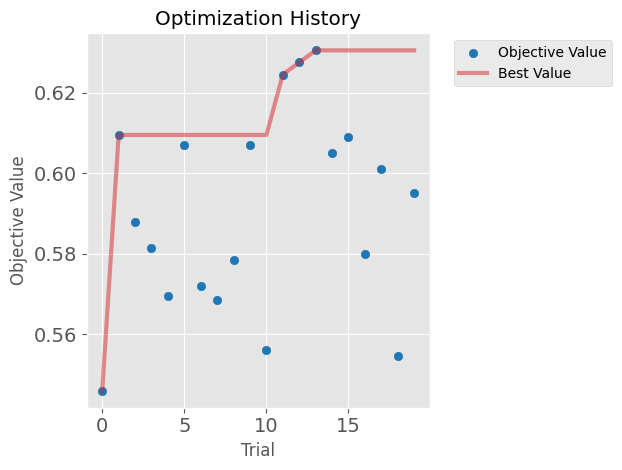

/tmp/ipykernel_6968/3970159883.py:7: ExperimentalWarning: optuna.visualization.matplotlib._param_importances.plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_param_importances(study)


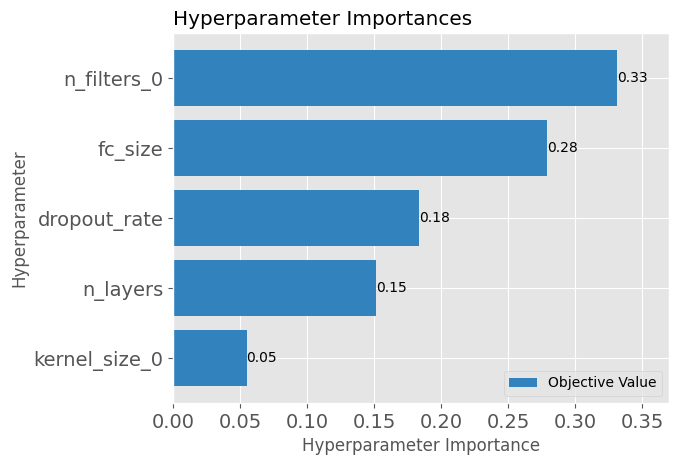

/tmp/ipykernel_6968/3970159883.py:10: ExperimentalWarning: optuna.visualization.matplotlib._parallel_coordinate.plot_parallel_coordinate is experimental (supported from v2.2.0). The interface can change in the future.
  ax = optuna.visualization.matplotlib.plot_parallel_coordinate(


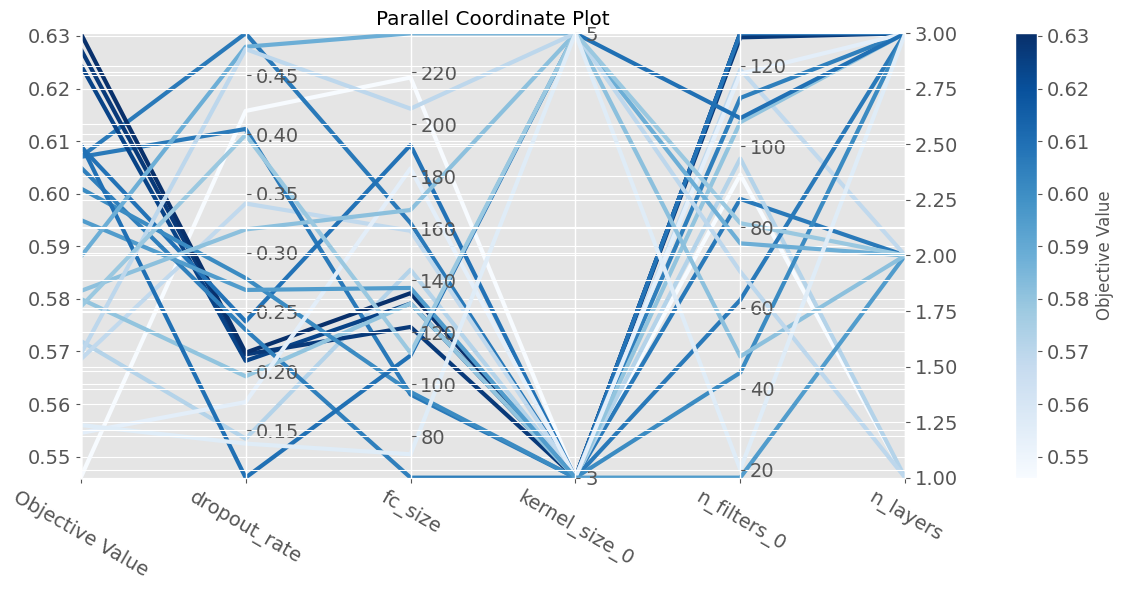

In [8]:
# Plotting the optimization history
optuna.visualization.matplotlib.plot_optimization_history(study)
plt.title('Optimization History')
plt.show()

# Importance of hyperparameters
optuna.visualization.matplotlib.plot_param_importances(study)
plt.show()

ax = optuna.visualization.matplotlib.plot_parallel_coordinate(
    study, params=['n_layers', 'n_filters_0', 'kernel_size_0', 'dropout_rate', 'fc_size']
)
fig = ax.figure
fig.set_size_inches(12, 6, forward=True)  # forward=True updates the canvas
fig.tight_layout()

## (Opcional) Comparando Grid Search con la búsqueda por defecto de Optuna

En esta sección, compararás el rendimiento del algoritmo de búsqueda por defecto de Optuna con un enfoque de Grid Search.
Grid Search es un método tradicional para la optimización de hiperparámetros que busca de manera exhaustiva a través de un conjunto predefinido de combinaciones de hiperparámetros.
Aunque puede ser efectivo, a menudo es computacionalmente costoso y puede que no explore el espacio de búsqueda de manera tan eficiente como los algoritmos adaptativos de Optuna.

Para realizar la comparación, se utiliza un ejemplo más simple, como el de los laboratorios anteriores. 
Se utiliza el modelo `FlexibleSimpleCNN` en un dataset más pequeño, que consiste en un subconjunto de [Fruit and Vegetable Disease (Healthy vs Rotten)](https://www.kaggle.com/datasets/muhammad0subhan/fruit-and-vegetable-disease-healthy-vs-rotten).
Este dataset contiene imágenes de frutas y verduras saludables y podridas. 
Utilizarás únicamente un subconjunto personalizado del dataset, que contiene 1200 imágenes de manzanas, siendo 1000 saludables y 200 podridas.

In [9]:
class FlexibleSimpleCNN(nn.Module):
    """
    Una Red Neuronal Convolucional simple y flexible.

    Esta red consta de dos capas convolucionales, cada una seguida de una
    capa de max-pooling, y dos capas totalmente conectadas (fully connected). 
    El número de filtros en las capas convolucionales y el tamaño de la capa 
    lineal oculta son configurables, lo que hace que la arquitectura sea 
    adaptable a diferentes requerimientos.
    """
    def __init__(self, conv1_out, conv2_out, fc_size, num_classes):
        """
        Inicializa las capas de la CNN.

        Args:
            conv1_out: El número de canales de salida para la primera
                       capa convolucional.
            conv2_out: El número de canales de salida para la segunda
                       capa convolucional.
            fc_size: El número de neuronas en la capa oculta totalmente conectada.
            num_classes: El número de clases de salida para la capa final.
        """
        super(FlexibleSimpleCNN, self).__init__()
        # Define la primera capa convolucional
        self.conv1 = nn.Conv2d(3, conv1_out, kernel_size=3, padding=1)
        # Define la segunda capa convolucional
        self.conv2 = nn.Conv2d(conv1_out, conv2_out, kernel_size=3, padding=1)
        # Define una capa de max pooling para ser usada después de cada convolución
        self.pool = nn.MaxPool2d(2, 2)
        
        # Define la primera capa totalmente conectada (oculta)
        # Asume que las imágenes de entrada son de 32x32, resultando en un mapa de 
        # características de 8x8 después de dos capas de pooling.
        self.fc1 = nn.Linear(conv2_out * 8 * 8, fc_size)
        # Define la capa final totalmente conectada (salida)
        self.fc2 = nn.Linear(fc_size, num_classes)

    def forward(self, x):
        """
        Define el forward pass de la red.

        Args:
            x: El tensor de entrada de forma (batch_size, channels, height, width).

        Returns:
            Los logits de salida de la red.
        """
        # Aplica el primer bloque convolucional: convolución, activación ReLU y pooling
        x = self.pool(F.relu(self.conv1(x)))
        # Aplica el segundo bloque convolucional
        x = self.pool(F.relu(self.conv2(x)))
        # Aplana el mapa de características para preparar las capas totalmente conectadas
        x = x.view(x.size(0), -1)
        # Pasa a través de la primera capa totalmente conectada con activación ReLU
        x = F.relu(self.fc1(x))
        # Pasa a través de la capa de salida final
        x = self.fc2(x)
        # Retorna los logits resultantes
        return x

El objetivo del modelo es clasificar las imágenes en dos clases: saludables (healthy) y podridas (rotten).
Ten en cuenta que el dataset está desbalanceado (imbalanced), con un mayor número de imágenes saludables en comparación con las podridas.
En tales casos, el accuracy no es la mejor métrica para evaluar el rendimiento del modelo, ya que puede ser engañoso debido al desbalance de clases.
Por lo tanto, se utilizará el **F1 score como métrica de evaluación**, ya que es más adecuado para datasets desbalanceados.
Para asegurar una comparación justa entre Grid Search y la búsqueda de Optuna, se utilizará el mismo espacio de hiperparámetros para ambos enfoques.

También utilizarás el método `trial.set_user_attr`, que te permite almacenar información adicional en cada objeto trial, como accuracy, recall, precision y F1 score.
Esto es útil para rastrear métricas adicionales que pueden ser analizadas más tarde.

**Por qué no se necesita una entrada ficticia (dummy input) aquí**: A diferencia del `FlexibleCNN` utilizado anteriormente, el `FlexibleSimpleCNN` utilizado en esta sección no requiere una entrada ficticia para inicializar sus parámetros.

- **Inicialización Estática**: En `FlexibleSimpleCNN`, las capas del clasificador (`self.fc1` y `self.fc2`) se definen directamente dentro del método `__init__` basándose en una entrada fija, en lugar de crearse dinámicamente durante el primer forward pass.
- **Seguridad del Optimizer**: Debido a que estas capas existen inmediatamente después de la instanciación del modelo, `model.parameters()` incluye correctamente los pesos del clasificador desde el principio. Por lo tanto, el optimizer rastreará y entrenará el clasificador correctamente sin necesidad de una pasada de "calentamiento" (warm-up pass).

In [10]:
def objective_apples(trial, device):
    """
    Define la función objetivo de Optuna para una CNN en un dataset de manzanas.

    Para cada trial, esta función muestrea hiperparámetros para una arquitectura
    CNN, entrena el modelo en un dataset personalizado de manzanas y evalúa
    su rendimiento. Registra el accuracy, precision y recall, mientras
    devuelve el F1-score como la métrica principal para que Optuna la optimice.

    Args:
        trial: Un objeto `Trial` de Optuna utilizado para muestrear hiperparámetros.
        device: El dispositivo ('cpu' o 'cuda') para el entrenamiento y evaluación del modelo.

    Returns:
        El F1-score del modelo entrenado en el conjunto de validación.
    """
    # Muestrear un conjunto de hiperparámetros para la arquitectura del modelo
    conv1_out = trial.suggest_int("conv1_out", 8, 64, step=8)
    conv2_out = trial.suggest_int("conv2_out", 16, 128, step=16)
    fc_size = trial.suggest_int("fc_size", 32, 256, step=32)

    # Definir parámetros fijos para los data loaders
    img_size = 32
    batch_size = 128

    # Crear los data loaders de entrenamiento y validación para el dataset de manzanas
    train_loader, val_loader = helper_utils.get_apples_dataset_dataloaders(
        img_size=img_size, 
        batch_size=batch_size
    )

    # Especificar el número de clases de salida para el dataset
    num_classes = 2
    # Crear una instancia del modelo con los hiperparámetros muestreados
    model = FlexibleSimpleCNN(
        conv1_out=conv1_out,
        conv2_out=conv2_out,
        fc_size=fc_size,
        num_classes=num_classes
    ).to(device)
    
    # Definir componentes de entrenamiento fijos: learning rate, optimizer y loss function
    learning_rate = 0.001
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    loss_fcn = nn.CrossEntropyLoss()

    # Establecer el número fijo de epochs para el bucle de entrenamiento
    n_epochs = 5
    # Entrenar el modelo utilizando una función auxiliar (helper function)
    helper_utils.train_model(
        model=model,
        optimizer=optimizer,
        train_dataloader=train_loader,
        n_epochs=n_epochs,
        loss_fcn=loss_fcn,
        device=device
    )

    # Evaluar el modelo entrenado en el conjunto de validación para obtener métricas de rendimiento
    accuracy, precision, recall, f1 = helper_utils.evaluate_metrics(
        model, val_loader, device, num_classes=2
    )

    # Registrar métricas adicionales en el trial de Optuna para un análisis más detallado
    trial.set_user_attr("accuracy", accuracy)
    trial.set_user_attr("precision", precision)
    trial.set_user_attr("recall", recall)

    # Devolver el F1-score como el valor objetivo para que Optuna lo maximice
    return f1

Con la función objetivo definida, ahora puedes ejecutar tanto el algoritmo de búsqueda por defecto de Optuna como el algoritmo de Grid Search. Ambos métodos se ejecutarán para el mismo número de trials y los resultados se compararán utilizando la función `plot_optimization_history`.

Primero, en este caso, especificarás `sampler = optuna.samplers.TPESampler(seed=42)` (el sampler por defecto en Optuna), que es el Tree-structured Parzen Estimator (TPE). El sampler TPE es un algoritmo sofisticado que adapta el espacio de búsqueda basándose en los resultados de los trials anteriores, lo que permite una exploración más eficiente del espacio de hiperparámetros. Luego, crearás un objeto study con el sampler deseado y establecerás `direction='maximize'` para indicar que deseas maximizar la función objetivo (en este caso, el F1 score). Observa que el DataFrame de los trials ahora incluye columnas adicionales para accuracy, recall y precision, las cuales fueron establecidas utilizando el método `trial.set_user_attr` dentro de la función objetivo.

A continuación, ejecuta el grid search sampler (`sampler = optuna.samplers.GridSampler(param_grid)`) para explorar el espacio de hiperparámetros. El Grid Search iterará, hasta alcanzar el número de trials definido, sobre todas las combinaciones posibles de hiperparámetros en el grid, evaluando la función objetivo para cada configuración única sin repetir ninguna combinación.

In [11]:
seed = 42
helper_utils.set_seed(seed)

# Usar el sampler TPE (el sampler por defecto en Optuna)
sampler = optuna.samplers.TPESampler(seed=seed) 

# Crear un objeto de estudio (study) y optimizar la función objetivo
study_apples = optuna.create_study(direction='maximize', sampler=sampler)

# Iniciar el proceso de optimización
n_trials = 10
study_apples.optimize(lambda trial: objective_apples(trial, device), n_trials=n_trials)

[I 2026-01-26 12:54:05,982] A new study created in memory with name: no-name-1ac1723c-63e1-4afc-a866-6fd31ee8d796


{'healthy': 0, 'rotten': 1}


Current Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Current Batch:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 5 - Train Loss: 0.3548
Training complete!



[I 2026-01-26 12:54:46,654] Trial 0 finished with value: 0.6255446672439575 and parameters: {'conv1_out': 24, 'conv2_out': 128, 'fc_size': 192}. Best is trial 0 with value: 0.6255446672439575.


{'healthy': 0, 'rotten': 1}


Current Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Current Batch:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 5 - Train Loss: 0.4515
Training complete!



[I 2026-01-26 12:55:15,075] Trial 1 finished with value: 0.439461886882782 and parameters: {'conv1_out': 40, 'conv2_out': 32, 'fc_size': 64}. Best is trial 0 with value: 0.6255446672439575.


{'healthy': 0, 'rotten': 1}


Current Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Current Batch:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 5 - Train Loss: 0.3359
Training complete!



[I 2026-01-26 12:55:44,129] Trial 2 finished with value: 0.7176079750061035 and parameters: {'conv1_out': 8, 'conv2_out': 112, 'fc_size': 160}. Best is trial 2 with value: 0.7176079750061035.


{'healthy': 0, 'rotten': 1}


Current Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Current Batch:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 5 - Train Loss: 0.3461
Training complete!



[I 2026-01-26 12:56:13,282] Trial 3 finished with value: 0.6919227838516235 and parameters: {'conv1_out': 48, 'conv2_out': 16, 'fc_size': 256}. Best is trial 2 with value: 0.7176079750061035.


{'healthy': 0, 'rotten': 1}


Current Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Current Batch:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 5 - Train Loss: 0.3534
Training complete!



[I 2026-01-26 12:56:42,536] Trial 4 finished with value: 0.8412935733795166 and parameters: {'conv1_out': 56, 'conv2_out': 32, 'fc_size': 64}. Best is trial 4 with value: 0.8412935733795166.


{'healthy': 0, 'rotten': 1}


Current Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Current Batch:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 5 - Train Loss: 0.3716
Training complete!



[I 2026-01-26 12:57:11,102] Trial 5 finished with value: 0.5040310621261597 and parameters: {'conv1_out': 16, 'conv2_out': 48, 'fc_size': 160}. Best is trial 4 with value: 0.8412935733795166.


{'healthy': 0, 'rotten': 1}


Current Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Current Batch:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 5 - Train Loss: 0.2959
Training complete!



[I 2026-01-26 12:57:40,447] Trial 6 finished with value: 0.7342193126678467 and parameters: {'conv1_out': 32, 'conv2_out': 48, 'fc_size': 160}. Best is trial 4 with value: 0.8412935733795166.


{'healthy': 0, 'rotten': 1}


Current Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Current Batch:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 5 - Train Loss: 0.2838
Training complete!



[I 2026-01-26 12:58:06,876] Trial 7 finished with value: 0.858942985534668 and parameters: {'conv1_out': 16, 'conv2_out': 48, 'fc_size': 96}. Best is trial 7 with value: 0.858942985534668.


{'healthy': 0, 'rotten': 1}


Current Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Current Batch:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 5 - Train Loss: 0.3140
Training complete!



[I 2026-01-26 12:58:35,937] Trial 8 finished with value: 0.9125000238418579 and parameters: {'conv1_out': 32, 'conv2_out': 112, 'fc_size': 64}. Best is trial 8 with value: 0.9125000238418579.


{'healthy': 0, 'rotten': 1}


Current Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Current Batch:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 5 - Train Loss: 0.3694
Training complete!



[I 2026-01-26 12:59:04,237] Trial 9 finished with value: 0.677465558052063 and parameters: {'conv1_out': 40, 'conv2_out': 80, 'fc_size': 32}. Best is trial 8 with value: 0.9125000238418579.


In [12]:
df_apples_study = study_apples.trials_dataframe()

df_apples_study

,number,value,datetime_start,datetime_complete,duration,params_conv1_out,params_conv2_out,params_fc_size,user_attrs_accuracy,user_attrs_precision,user_attrs_recall,state
0,0,0.625545,2026-01-26 12:54:05.994744,2026-01-26 12:54:46.654339,0 days 00:00:40.659595,24,128,192,0.824,0.839588,0.606009,COMPLETE
1,1,0.439462,2026-01-26 12:54:46.655902,2026-01-26 12:55:15.075442,0 days 00:00:28.419540,40,32,64,0.784,0.392000,0.500000,COMPLETE
2,2,0.717608,2026-01-26 12:55:15.077987,2026-01-26 12:55:44.128942,0 days 00:00:29.050955,8,112,160,0.864,0.860886,0.676211,COMPLETE
3,3,0.691923,2026-01-26 12:55:44.131991,2026-01-26 12:56:13.282829,0 days 00:00:29.150838,48,16,256,0.868,0.807815,0.654647,COMPLETE
4,4,0.841294,2026-01-26 12:56:13.285957,2026-01-26 12:56:42.536711,0 days 00:00:29.250754,56,32,64,0.932,0.925148,0.792602,COMPLETE
5,5,0.504031,2026-01-26 12:56:42.539483,2026-01-26 12:57:11.102796,0 days 00:00:28.563313,16,48,160,0.812,0.904858,0.530000,COMPLETE
6,6,0.734219,2026-01-26 12:57:11.105169,2026-01-26 12:57:40.447288,0 days 00:00:29.342119,32,48,160,0.872,0.930736,0.686275,COMPLETE
7,7,0.858943,2026-01-26 12:57:40.449315,2026-01-26 12:58:06.876707,0 days 00:00:26.427392,16,48,96,0.916,0.899405,0.830574,COMPLETE
8,8,0.912500,2026-01-26 12:58:06.879004,2026-01-26 12:58:35.937217,0 days 00:00:29.058213,32,112,64,0.944,0.912500,0.912500,COMPLETE
9,9,0.677466,2026-01-26 12:58:35.938999,2026-01-26 12:59:04.237351,0 days 00:00:28.298352,40,80,32,0.856,0.840949,0.641547,COMPLETE


In [13]:
# Ejecutar con Grid Search Sampler

# Definir el grid (rejilla) de hiperparámetros
param_grid = {
    "conv1_out": list(range(8, 65, 8)),       # [8, 16, 24, 32, 40, 48, 56, 64]
    "conv2_out": list(range(16, 129, 16)),    # [16, 32, 48, 64, 80, 96, 112, 128]
    "fc_size":   list(range(32, 257, 32))     # [32, 64, 96, 128, 160, 192, 224, 256]
}

# Crear un GridSampler con el grid definido
grid_sampler = optuna.samplers.GridSampler(param_grid, seed=seed)  # Usar semilla para reproducibilidad

# Crear un objeto de estudio (study) con el GridSampler
study_grid = optuna.create_study(direction='maximize', sampler=grid_sampler)

# Iniciar la optimización (ejecutará el mismo número de trials para comparar)
study_grid.optimize(lambda trial: objective_apples(trial, device), n_trials=n_trials)

[I 2026-01-26 12:59:49,711] A new study created in memory with name: no-name-4ea5d5cb-b28c-49b5-934a-c0f79f1c1ce5


{'healthy': 0, 'rotten': 1}


Current Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Current Batch:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 5 - Train Loss: 0.3343
Training complete!



[I 2026-01-26 13:00:19,184] Trial 0 finished with value: 0.4343891441822052 and parameters: {'conv1_out': 40, 'conv2_out': 112, 'fc_size': 32}. Best is trial 0 with value: 0.4343891441822052.


{'healthy': 0, 'rotten': 1}


Current Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Current Batch:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 5 - Train Loss: 0.3423
Training complete!



[I 2026-01-26 13:00:47,303] Trial 1 finished with value: 0.44933921098709106 and parameters: {'conv1_out': 64, 'conv2_out': 96, 'fc_size': 256}. Best is trial 1 with value: 0.44933921098709106.


{'healthy': 0, 'rotten': 1}


Current Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Current Batch:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 5 - Train Loss: 0.2646
Training complete!



[I 2026-01-26 13:01:16,982] Trial 2 finished with value: 0.8049752712249756 and parameters: {'conv1_out': 56, 'conv2_out': 112, 'fc_size': 256}. Best is trial 2 with value: 0.8049752712249756.


{'healthy': 0, 'rotten': 1}


Current Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Current Batch:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 5 - Train Loss: 0.2777
Training complete!



[I 2026-01-26 13:01:46,430] Trial 3 finished with value: 0.8275692462921143 and parameters: {'conv1_out': 24, 'conv2_out': 64, 'fc_size': 64}. Best is trial 3 with value: 0.8275692462921143.


{'healthy': 0, 'rotten': 1}


Current Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Current Batch:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 5 - Train Loss: 0.3034
Training complete!



[I 2026-01-26 13:02:17,471] Trial 4 finished with value: 0.8207193613052368 and parameters: {'conv1_out': 64, 'conv2_out': 112, 'fc_size': 64}. Best is trial 3 with value: 0.8275692462921143.


{'healthy': 0, 'rotten': 1}


Current Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Current Batch:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 5 - Train Loss: 0.4426
Training complete!



[I 2026-01-26 13:02:44,901] Trial 5 finished with value: 0.45652174949645996 and parameters: {'conv1_out': 24, 'conv2_out': 16, 'fc_size': 128}. Best is trial 3 with value: 0.8275692462921143.


{'healthy': 0, 'rotten': 1}


Current Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Current Batch:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 5 - Train Loss: 0.3235
Training complete!



[I 2026-01-26 13:03:13,224] Trial 6 finished with value: 0.7238179445266724 and parameters: {'conv1_out': 32, 'conv2_out': 32, 'fc_size': 160}. Best is trial 3 with value: 0.8275692462921143.


{'healthy': 0, 'rotten': 1}


Current Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Current Batch:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 5 - Train Loss: 0.2881
Training complete!



[I 2026-01-26 13:03:43,022] Trial 7 finished with value: 0.691718578338623 and parameters: {'conv1_out': 64, 'conv2_out': 128, 'fc_size': 96}. Best is trial 3 with value: 0.8275692462921143.


{'healthy': 0, 'rotten': 1}


Current Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Current Batch:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 5 - Train Loss: 0.3744
Training complete!



[I 2026-01-26 13:04:11,172] Trial 8 finished with value: 0.5978121161460876 and parameters: {'conv1_out': 48, 'conv2_out': 16, 'fc_size': 192}. Best is trial 3 with value: 0.8275692462921143.


{'healthy': 0, 'rotten': 1}


Current Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Current Batch:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 5 - Train Loss: 0.2829
Training complete!



[I 2026-01-26 13:04:39,200] Trial 9 finished with value: 0.7767857313156128 and parameters: {'conv1_out': 32, 'conv2_out': 112, 'fc_size': 256}. Best is trial 3 with value: 0.8275692462921143.


/tmp/ipykernel_6968/2658579028.py:2: ExperimentalWarning: optuna.visualization.matplotlib._optimization_history.plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study_apples)


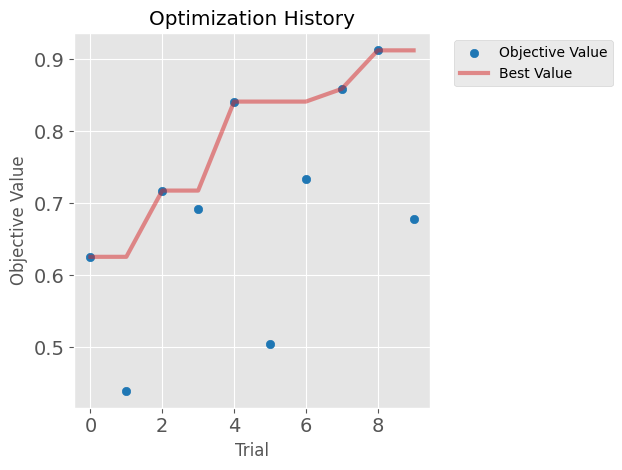

/tmp/ipykernel_6968/2658579028.py:7: ExperimentalWarning: optuna.visualization.matplotlib._optimization_history.plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study_grid)


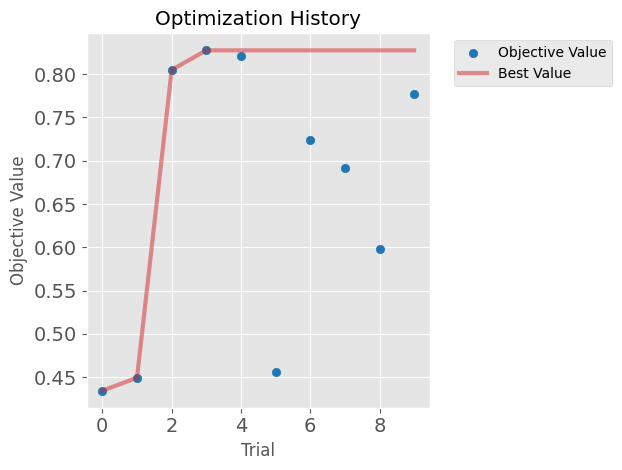

In [14]:
# Plotting the optimization history
optuna.visualization.matplotlib.plot_optimization_history(study_apples)
plt.title('Optimization History')
plt.show()

# Plotting the optimization history
optuna.visualization.matplotlib.plot_optimization_history(study_grid)
plt.title('Optimization History')
plt.show()

Bajo el enfoque de Grid Search, los valores del objetivo varían significativamente porque todas las combinaciones posibles de hiperparámetros en el grid se evalúan exhaustivamente.  
Dado que Grid Search no tiene en cuenta el rendimiento de los trials anteriores, puede desperdiciar recursos evaluando muchas configuraciones subóptimas, especialmente en espacios de hiperparámetros de alta dimensión o redundantes.

En contraste, el algoritmo de búsqueda de Optuna emplea una estrategia de muestreo adaptativa e inteligente (como TPE).  
Utiliza los resultados de los trials anteriores para guiar la búsqueda hacia regiones más prometedoras del espacio de hiperparámetros, permitiendo una exploración más eficiente y enfocada. Como resultado, Optuna suele ser capaz de identificar configuraciones de hiperparámetros con mejor rendimiento con menos trials en comparación con Grid Search.

Cuanto más grande y complejo se vuelve el espacio de búsqueda, más pronunciada es la ventaja de los métodos de muestreo adaptativo como Optuna sobre los métodos exhaustivos como Grid Search.

## Conclusión

¡Felicitaciones por completar el tutorial de optimización de hiperparámetros con Optuna!

En este notebook, exploraste los componentes clave de un flujo de trabajo de optimización basado en Optuna: definir la función objetivo, configurar el estudio y analizar los resultados. También construiste una arquitectura CNN flexible diseñada para adaptarse a diversas configuraciones de hiperparámetros, lo que permite una experimentación más dinámica.

Además, comparaste el algoritmo de búsqueda por defecto de Optuna (TPE) con un grid search tradicional, demostrando la eficiencia y adaptabilidad de Optuna para navegar en espacios de hiperparámetros complejos. A lo largo del tutorial, evaluaste el rendimiento del modelo utilizando múltiples métricas y aprendiste a interpretar los resultados a través de las potentes herramientas de visualización de Optuna.

Al final de este tutorial, has adquirido una comprensión práctica y conceptual de cómo integrar Optuna en proyectos de Deep Learning, equipándote con una habilidad valiosa para optimizar el rendimiento de los modelos de manera eficiente y efectiva.